In [1]:
import pandas as pd
import numpy as np

import yfinance as yf
import datetime as dt

from matplotlib import pyplot as plt

from importlib import reload

import download_data as dd
reload(dd)

<module 'download_data' from 'C:\\Users\\Jeffrey\\Desktop\\Homework\\Market-Markov\\download_data.py'>

# Set Controls

#### Time of Program

In [2]:
start = dt.datetime(2010,1,1)
end = dt.datetime(2020,12,31)

#### Basket of Stocks

In [10]:
symbols = ['SPYG', 'SPYD', 'SPY']
symbols = ['SPYG', 'SPYD', 'SPY', 'MSFT', 'AMZN', 'TSLA', 'AAPL']

In [13]:
def download_stock_data(symbol, start, end):
    """Downloads historical stock pricing data for an individual symbol"""

    df = pd.DataFrame()  

    # Print the symbol being downloaded
    print('DOWNLOADING ' + symbol, sep=',', end=' ... ', flush=True)  

    try:
        # Download pricing data
        stock = []
        stock = yf.download(symbol, start=start, end=end, progress=False)

        # Append individual prices
        if len(stock) == 0:
            None
        else:
            stock['Name'] = symbol
            df = df.append(stock,sort=False)
            df = df[['Close', 'Name']]
            print('SUCCESS!')
            
    except Exception:
        print('ERROR IN DOWNLOADING DATA')
               
    
    return df



def day_change_transitions(df, num_days):
    """Calculates a measure of change from good/middle/bad days sto good/middle/bad."""
    
    # Controls
    min_change = 0.01
    
    # How has the stock performed in the last X days?
    df[str(num_days)+'D Change'] = df['Close'] - df.loc[:,'Close'].shift(num_days)
    df[str(num_days)+'D Change Switch'] = np.where(df[str(num_days)+'D Change'] > 0, True, False)

    # Is the change significant?
    df['Change Percent Value'] = np.absolute(df[str(num_days)+'D Change'] / df['Close'])
    df['Change Percent Value Switch'] = np.where(df['Change Percent Value'] > min_change, True, False)

    # Combine everything
    conditions = [
        (df[str(num_days)+'D Change Switch'] == True) & (df['Change Percent Value Switch'] == True),
        (df[str(num_days)+'D Change Switch'] == False) & (df['Change Percent Value Switch'] == True),
        (df['Change Percent Value Switch'] == False)]
    
    # Assign categories
    choices = [0, 1, 2]
    df['Output'] = np.select(conditions, choices, default = 2)
    
    # Isolate transitions
    transitions = list(df['Output'])[num_days:]

    # Plot it because it pretty
    #df[['Close', str(num_days)+'D Change']].plot()
    #plt.show()
    
    return transitions



def generate_transition_matrix(l, split_size):
    """Generates a transition matrix from a list of data"""
    
    # Identify all unique elements and create an empty transition matrix
    elements = list(set(l))
    elements_len = len(elements)
    transition_matrix = [[0] * elements_len for x in range(elements_len)]

    # Create a zipped pair of each state and its next, and then a transition matrix
    for (i,j) in zip(l,l[split_size:]):
        transition_matrix[i][j] += 1
    for i in transition_matrix:
        if sum(i) > 0:
            i[:] = [x/sum(i) for x in i]
    
    return transition_matrix



def generate_combine_transition_matrices(symbols, start, end, min_days = 1, max_days = 1):
    """Runs each part of the progrm for each symbol and combines the transition matrices"""
    
    list_tm = []
    
    # Generate transition matrix for each symbol
    for i in symbols:
        df = download_stock_data(i, start, end)
        list_inner_tm = []
        for j in list(range(min_days, max_days + 1)):
            transitions = day_change_transitions(df, j)
            transition_matrix = generate_transition_matrix(transitions, j)
            list_inner_tm.append(transition_matrix)
        list_tm.append(list_inner_tm)
    
    # Average transition matrix for each symbol, this still satisfies Kolmogorov axioms
    avg_list, first, c_s = [], True, 0
    for i in list_tm:
        c = 0
        print(i.index)
        for j in i:
            try:
                if first == True:
                    avg_list.append(np.array(j))
                else:
                    avg_list[c] = avg_list[c] + np.array(j)
                    c = c + 1
            except:
                print('ERROR OCCURS AT ENTRY '+str(c)+' FOR EQUITY '+symbols[c_s])
                c = c + 1
                continue
        first = False
        c_s = c_s + 1
    for k in range(0, len(avg_list)):
        avg_list[k] = avg_list[k] / len(symbols)

    return avg_list
    


def stationary_values(transition_matrix, mmult_number = 50):
    """From a transition matrix, generate stationary values"""
            
    # Create a 1st state array
    state = np.array([[0.0] * len(transition_matrix)])
    state[0][0] = 1.0

    # Create a state tracker
    stateHist = state
    dfStateHist = pd.DataFrame(state)
    distr_hist = [[0,0]]
    
    # Calculate stationary values
    for x in range(mmult_number):
        state = np.dot(state, transition_matrix)
        stateHist = np.append(stateHist,state,axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
    svals = dfDistrHist[-1:].iloc[0]
        
    return svals

In [14]:
tms = generate_combine_transition_matrices(symbols, start=start, end=end, min_days = 1, max_days = 100)

DOWNLOADING SPYG ... SUCCESS!
DOWNLOADING SPYD ... SUCCESS!
DOWNLOADING SPY ... SUCCESS!
DOWNLOADING MSFT ... SUCCESS!
DOWNLOADING AMZN ... SUCCESS!
DOWNLOADING TSLA ... SUCCESS!
DOWNLOADING AAPL ... SUCCESS!
<built-in method index of list object at 0x000001D5A089CCC0>
<built-in method index of list object at 0x000001D5A089E740>
<built-in method index of list object at 0x000001D5A08B7740>
<built-in method index of list object at 0x000001D5A088C980>
<built-in method index of list object at 0x000001D5A0864480>
<built-in method index of list object at 0x000001D5A0877340>
<built-in method index of list object at 0x000001D5A088C940>


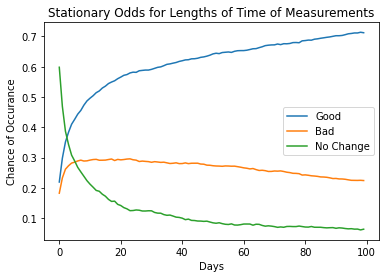

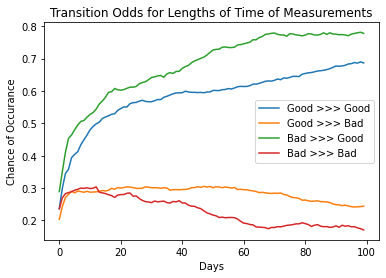

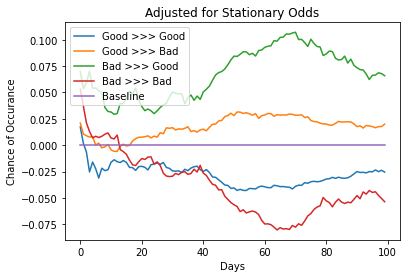

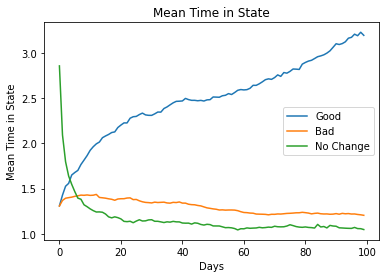

In [15]:
plot_summaries(tms)

In [8]:
def plot_summaries(tms):
    """"""
    l_stationary = []
    for _ in tms:
        l_stationary.append(list(stationary_values([list(x) for x in _])))

    for j in range(0, 3):
        x = [x[j] for x in l_stationary]
        plt.plot(x)
    plt.legend(['Good', 'Bad', 'No Change'])
    plt.title('Stationary Odds for Lengths of Time of Measurements')
    plt.ylabel('Chance of Occurance')
    plt.xlabel('Days')
    plt.show()
    
    for i in range(0, 2):
        for j in range(0, 2):
            x = np.array([x[i][j] for x in tms])
            plt.plot(x)
    plt.legend(['Good >>> Good', 'Good >>> Bad', 'Bad >>> Good', 'Bad >>> Bad'])
    plt.title('Transition Odds for Lengths of Time of Measurements')
    plt.ylabel('Chance of Occurance')
    plt.xlabel('Days')
    plt.show()
    
    for i in range(0, 2):
        for j in range(0, 2):
            x = np.array([x[i][j] for x in tms])
            x = x - [x[j] for x in l_stationary]
            plt.plot(x)
    # Plot single line
    plt.plot([0 for x in x])
    plt.legend(['Good >>> Good', 'Good >>> Bad', 'Bad >>> Good', 'Bad >>> Bad', 'Baseline'])
    plt.title('Adjusted for Stationary Odds')
    plt.ylabel('Chance of Occurance')
    plt.xlabel('Days')
    plt.show()
    
    for i in range(0, 3):
        x = np.array([1/(1-x[i][i]) if x[i][i] else None for x in tms])        
        plt.plot(x)
    plt.legend(['Good', 'Bad', 'No Change'])
    plt.title('Mean Time in State')
    plt.ylabel('Mean Time in State')
    plt.xlabel('Days')
    plt.show()
    
    
    return None